In [1]:
import os
import math
import numpy as np
import pandas as pd
from datetime import datetime, date, timedelta, time
os.environ['TZ'] ='America/New_York'

#import yfinance as yf

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

from ib_async import *
util.startLoop()

In [9]:
ib = IB()
ib.connect(port=7496, clientId=9)

<IB connected to 127.0.0.1:7496 clientId=9>

Error 1100, reqId -1: Connectivity between IBKR and Trader Workstation has been lost.
Error 1102, reqId -1: Connectivity between IBKR and Trader Workstation has been restored - data maintained. All data farms are connected: hfarm; usfarm.nj; cashfarm; usopt; usfarm; ushmds; secdefil.
Error 1100, reqId -1: Connectivity between IBKR and Trader Workstation has been lost.
Error 1102, reqId -1: Connectivity between IBKR and Trader Workstation has been restored - data maintained. All data farms are connected: hfarm; usfarm.nj; cashfarm; usopt; usfarm; ushmds; secdefil.
Error 162, reqId 8: Historical Market Data Service error message:API historical data query cancelled: 8, contract: Contract(secType='STK', conId=72539702, symbol='TQQQ', exchange='SMART', primaryExchange='NASDAQ', currency='USD', localSymbol='TQQQ', tradingClass='NMS')


In [103]:
def simple_data_req( contract, end_date , barsize ="5 mins", data_clean = True):

   
    df_acc=pd.DataFrame()
    df_hist=pd.DataFrame()

    for i in range(1):
        print(f'fetching data for {i}')
        end_date = end_date - timedelta(i)
        bars = ib.reqHistoricalData(contract= contract, endDateTime=end_date, barSizeSetting= barsize, durationStr= "230 D", whatToShow="TRADES", useRTH=True)
        df = util.df(bars)
        
        df_acc = pd.concat([df, df_acc], ignore_index=True)
        print(f'head date {df_acc.head(1)['date']}')
        print(f'tail date {df_acc.tail(1)['date']}')

    df_acc['Date_Only'] = df_acc['date'].dt.date
    
    if data_clean == True:
        df_hist = df_acc[(df_acc['date'].dt.time >= time(9, 30)) & (df_acc['date'].dt.time < time(16, 00))]
    else:
        df_hist = df_acc

    #df_hist.drop_duplicates(inplace=True)
    
    return df_hist

In [104]:
contract = Contract(symbol='TQQQ', secType='STK', exchange='SMART', currency='USD')
ib.qualifyContracts(contract)

[Contract(secType='STK', conId=72539702, symbol='TQQQ', exchange='SMART', primaryExchange='NASDAQ', currency='USD', localSymbol='TQQQ', tradingClass='NMS')]

In [105]:
now =datetime.now()
inferencing_date = now.date() -timedelta(0)

In [106]:
df_stock = simple_data_req(contract, inferencing_date,)

fetching data for 0
head date 0   2024-05-23 09:30:00-04:00
Name: date, dtype: datetime64[ns, US/Eastern]
tail date 17831   2025-04-24 15:55:00-04:00
Name: date, dtype: datetime64[ns, US/Eastern]


In [108]:
df_temp = df_stock.copy()

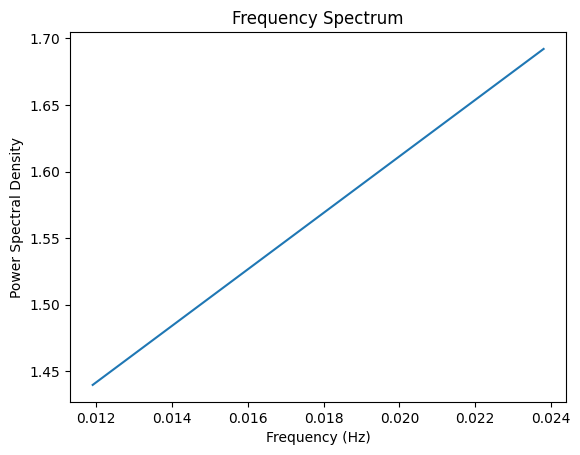

The dominant frequency is: 0.0 Hz


In [109]:
# 1. Compute the FFT
fft_values = np.fft.rfft(df_temp['close'][0+78*3:12+78*3])

# 2. Calculate Frequencies
sampling_rate = 1 / (12)  # Calculate sampling rate
frequencies = np.fft.fftfreq(len(fft_values), 1/sampling_rate)

# 3. Handle the Output (Compute PSD)
psd = np.abs(fft_values)**2

# 4. Plot the results
plt.plot(frequencies[1:len(frequencies)//2], psd[1:len(psd)//2]) # Plot only positive frequencies
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.title('Frequency Spectrum')
plt.show()

# Find dominant frequency
dominant_frequency_index = np.argmax(psd[:len(psd)//2])
dominant_frequency = frequencies[dominant_frequency_index]
print(f"The dominant frequency is: {dominant_frequency} Hz")

In [110]:
psd

array([6.05782022e+05, 1.43969178e+00, 1.69210000e+00, 5.20000000e-03,
       2.37900000e-01, 3.91108221e-01, 1.60000000e-03])

In [111]:
frequencies

array([ 0.        ,  0.01190476,  0.02380952,  0.03571429, -0.03571429,
       -0.02380952, -0.01190476])

<Axes: >

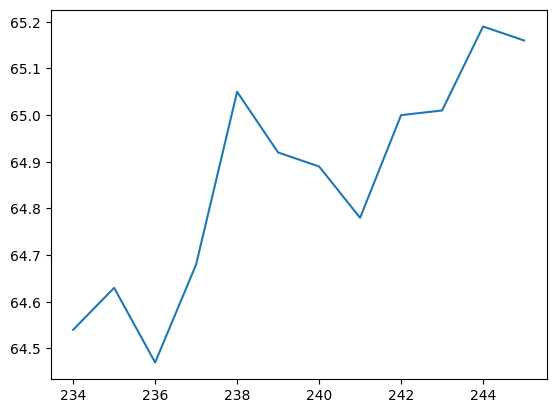

In [112]:
df_temp['close'][78*3:12+78*3].plot()

<Axes: >

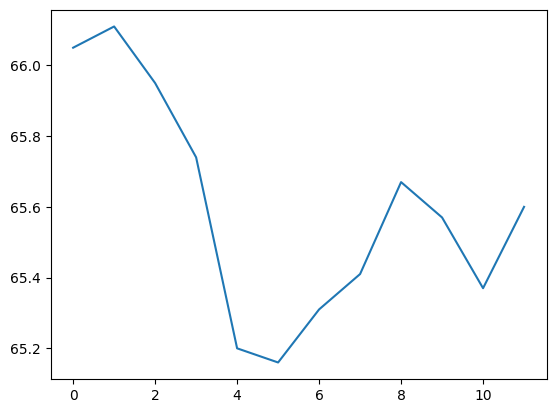

In [113]:
df_temp['close'][0:12].plot()


In [114]:
#df_stock['diff_close_open'] = df_stock['open'] - df_stock['close'].shift(1)
#df_stock['diff_close_open'] = df_stock['diff_close_open'].shift(2)

In [115]:
def distance(data, acc_volume):
    buy = data.close -data.low
    sell = data.high - data.close
    #dist_BS = (buy - sell)*data.volume/acc_volume
    dist_BS = (buy - sell)
    return dist_BS

In [116]:
def mid_price(data):
    mid = (data.high+data.low)/2
    return mid

In [196]:
df_ST = df_stock.copy()

In [197]:


def feature_creation(df, initial_acc, barsize=5 , df_train=pd.DataFrame(), stock_flag=True ):

    acc_distance = 0
    acc_volume = 0
    mid = []

    df['diff_pr_close_open'] = (df['open'] - df['close'].shift(1))/df['open']*100
    
    df['diff_pr_close_open'] = df['diff_pr_close_open'].shift(initial_acc)

    
    for n in range(229):   #  takeing out the last period out
        flag = ''

        Period = int(30/barsize + 6*60/barsize)*n
        acc_volume =  df.iloc[[0 + Period,1 + Period, 2+ Period ]].volume.sum()
        mid = []
    # need to find acc_volume first        
        for i in range(initial_acc):
            dist_BS = distance(df.iloc[i+Period], acc_volume)
            acc_distance += dist_BS
            mid.append(mid_price(df.iloc[i+Period]))
        
        mid_price_adj = (mid[initial_acc-1]- mid[0])/mid[0]*100

        #calculating fft values

        fft_values = np.fft.rfft(df['close'][0 + Period:initial_acc+ Period])

        # 2. Calculate Frequencies
        sampling_rate = 1 / (initial_acc)  # Calculate sampling rate
        frequencies = np.fft.fftfreq(len(fft_values), 1/sampling_rate)
        
        # 3. Handle the Output (Compute PSD)
        psd = np.abs(fft_values)**2

        df.loc[initial_acc + Period, 'PSD_1'] = psd[1]
        df.loc[initial_acc + Period, 'PSD_2'] = psd[2]
        df.loc[initial_acc + Period, 'PSD_3'] = psd[3]



        if stock_flag ==True:
            df['Target_30min'] = (df['close'] - df['close'].shift(-6))/df['close'] *100
            df['Target_15min'] = (df['close'] - df['close'].shift(-3))/df['close'] *100
            df['Target_1hr'] = (df['close'] - df['close'].shift(-12))/df['close'] *100
            df['Target_10min'] = (df['close'] - df['close'].shift(-2))/df['close'] *100

        
        df.loc[initial_acc + Period, 'acc_distance'] = acc_distance
        df.loc[initial_acc + Period, 'mid_price'] = mid_price_adj

        #if Period >= int(30/barsize + 6*60/barsize):
            
            #df.loc[initial_acc + Period, 'diff_open_pr_close'] = (df_stock.iloc[Period]['open'] - df_stock.iloc[Period -1]['close'])/df_stock.iloc[Period -1]['close']*100
        #    df.loc[initial_acc + Period, 'diff_open_pr_close'] = (df.iloc[Period]['open'] - df.iloc[Period -1]['close'])/df.iloc[Period -1]['close']*100

        df['diff_open_1hr'] = df['open'].diff(1)/df['open']*100
        df['diff_open_2hr'] = df['open'].diff(2)/df['open']*100
        #df_dum =pd.DataFrame()
        #df_dum['open'] = df['open']

        
        df['diff_high_1hr'] = df['high'].diff(1)/df['high']*100
        df['diff_high_2hr'] = df['high'].diff(2)/df['high']*100

        df['diff_low_1hr'] = df['low'].diff(1)/df['low']*100
        df['diff_low_2hr'] = df['low'].diff(2)/df['low']*100
        
        df['diff_close_1hr'] = df['close'].diff(1)/df['close']*100
        df['diff_close_2hr'] = df['close'].diff(2)/df['close']*100
        

        df_select = pd.DataFrame(df.iloc[initial_acc+Period])

        df_train = pd.concat([df_train,df_select.T], ignore_index=True)

                    
    df_train['high'] = (df_train['high']-df_train['open'])/df_train['open']*100
    df_train['low'] = (df_train['low']-df_train['open'])/df_train['open']*100
    df_train['close'] = (df_train['close']-df_train['open'])/df_train['open']*100
    df_train['open'] = (df_train['open']-df_train['open'])/df_train['open']*100


    return df, df_train 


In [198]:
df_test, df_train = feature_creation(df_ST, 12)

In [199]:
df_train[10:13]['PSD_1']

10    0.873206
11    0.722089
12    3.970208
Name: PSD_1, dtype: object

In [200]:
df_train.columns

Index(['date', 'open', 'high', 'low', 'close', 'volume', 'average', 'barCount',
       'Date_Only', 'diff_pr_close_open', 'PSD_1', 'PSD_2', 'PSD_3',
       'Target_30min', 'Target_15min', 'Target_1hr', 'Target_10min',
       'acc_distance', 'mid_price', 'diff_open_1hr', 'diff_open_2hr',
       'diff_high_1hr', 'diff_high_2hr', 'diff_low_1hr', 'diff_low_2hr',
       'diff_close_1hr', 'diff_close_2hr'],
      dtype='object')

In [201]:
df_train['Target_15min_cat'] = np.where(df_train['Target_15min'] > 0, 1, 0)
df_train['Target_30min_cat'] = np.where(df_train['Target_30min']  > 0, 1, 0)
df_train['Target_1hr_cat'] = np.where(df_train['Target_1hr'] > 0, 1, 0)
df_train['Target_10min_cat'] = np.where(df_train['Target_10min']  > 0, 1, 0)
df_train['Target_total'] = np.where(df_train['Target_15min_cat'] + df_train['Target_30min_cat'] +df_train['Target_1hr_cat'] >1, 1, 0 )

In [202]:
#df_train_clean = pd.concat([df_train, df_train_TQ_clean], axis=1)

df_model_train = df_train.drop(columns=['date', 'Date_Only'], axis=1).dropna()

In [203]:
df_model_train = df_model_train.astype(float)
#df_model_train.reset_index(inplace=True)
#df_model_train['Target_10min_cat'] = df_model_train['Target_10min_cat'].astype(int)

In [211]:
X = df_model_train.drop(['open','Target_30min','Target_1hr', 'Target_30min_cat','Target_1hr_cat','Target_15min', 'Target_15min_cat','Target_10min', 'Target_10min_cat', 'Target_total'], axis=1)  
#y = df_option['Target_std']
y = df_model_train['Target_30min_cat']

In [212]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [213]:
X_train.shape

(182, 20)

In [214]:
X_train

,high,low,close,volume,average,barCount,diff_pr_close_open,PSD_1,PSD_2,PSD_3,acc_distance,mid_price,diff_open_1hr,diff_open_2hr,diff_high_1hr,diff_high_2hr,diff_low_1hr,diff_low_2hr,diff_close_1hr,diff_close_2hr
151,0.012470,-0.399052,-0.087293,666491.0,80.026,2274.0,-0.012444,16.036098,0.2899,0.1825,24.58,-0.417602,0.735753,1.259509,-0.024938,0.723192,0.400651,0.913985,-0.062406,0.686470
56,0.236444,-0.110340,0.063052,404023.0,63.509,954.0,0.015788,1.219853,0.3601,0.2377,7.77,0.031583,0.078815,-0.063052,0.204435,0.110080,0.220925,0.157803,0.031506,0.157530
166,0.195088,-0.057379,0.137709,397228.0,87.215,1071.0,-0.022815,1.459183,0.3184,0.2385,27.94,-0.530156,-0.321322,-0.516410,-0.125988,-0.355057,0.022965,-0.183718,0.080220,-0.171900
70,0.144161,-0.112126,0.016018,166236.0,62.425,652.0,-0.015954,0.170435,0.5653,0.8200,9.31,-0.572701,-0.272305,-0.288323,-0.191939,-0.591811,0.000000,-0.320718,-0.016015,-0.256246
168,0.218792,-0.060775,0.218792,452681.0,82.343,919.0,-0.036832,1.200910,0.2881,0.4105,28.34,0.851768,-0.024310,0.097241,0.072771,0.169800,0.036487,0.121625,0.230443,0.194057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,0.158940,-0.344371,-0.304636,628296.0,75.438,2011.0,-0.013068,3.992353,1.4700,0.3700,12.04,-1.111620,-0.304636,-0.450331,-0.145464,-0.304152,-0.345561,-0.172780,-0.318852,-0.597848
15,0.068018,-0.421711,-0.244865,536337.0,73.371,1894.0,-0.233036,0.185885,2.2743,0.2960,2.38,0.967277,-0.326486,0.000000,-0.258293,-0.271887,-0.314208,-0.327869,-0.231829,-0.572753
93,0.140984,-0.169181,0.028197,296732.0,70.919,913.0,0.014039,0.466663,0.2149,0.0053,10.93,-0.126538,-0.211476,-0.380657,-0.154864,-0.309728,-0.169468,-0.211834,0.014094,-0.169133
180,0.034439,-0.286993,-0.126277,378714.0,86.975,866.0,0.000000,0.295118,0.0889,0.4500,32.76,0.051674,-0.218115,-0.413271,-0.240992,-0.378701,-0.057564,-0.414460,-0.137931,-0.356322


In [215]:
y_train.shape

(182,)

In [216]:
import xgboost as xgb


from sklearn.metrics import accuracy_score

# Load the iris dataset



# Split data into training and testing sets

# Create an XGBoost classifier
model = xgb.XGBClassifier(
    objective='binary:logistic',  # Specify the objective function for multi-class classification               # Specify the number of classes
    n_estimators=100,           # Number of boosting rounds (trees)
    learning_rate=0.1,          # Step size shrinkage to prevent overfitting
    max_depth=3,                # Maximum depth of a tree
    random_state=42             # Random seed for reproducibility
)

#model = XGBClassifier(objective='binary:logistic', random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.61


In [217]:
pd.DataFrame(index=X.columns,data=model.feature_importances_,columns=['Feature Importance'])

,Feature Importance
high,0.094889
low,0.038701
close,0.065702
volume,0.035606
average,0.077034
barCount,0.040347
diff_pr_close_open,0.034765
PSD_1,0.049807
PSD_2,0.041105
PSD_3,0.035036


In [218]:
import joblib
# Assuming 'model' is your trained model object
filename = 'xgb_model_up_down.joblib'
joblib.dump(model, filename)

['xgb_model_up_down.joblib']

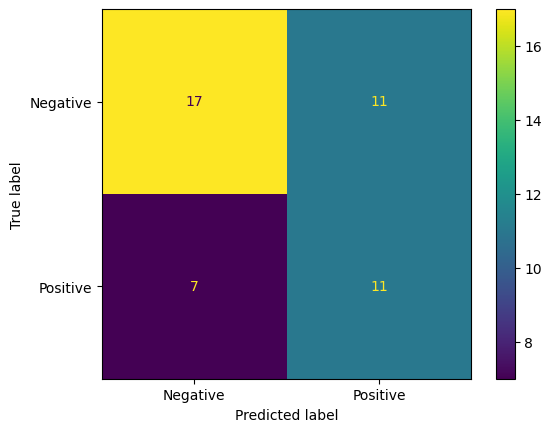

[[17 11]
 [ 7 11]]


In [219]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot()
plt.show()

# Print the confusion matrix
print(cm)

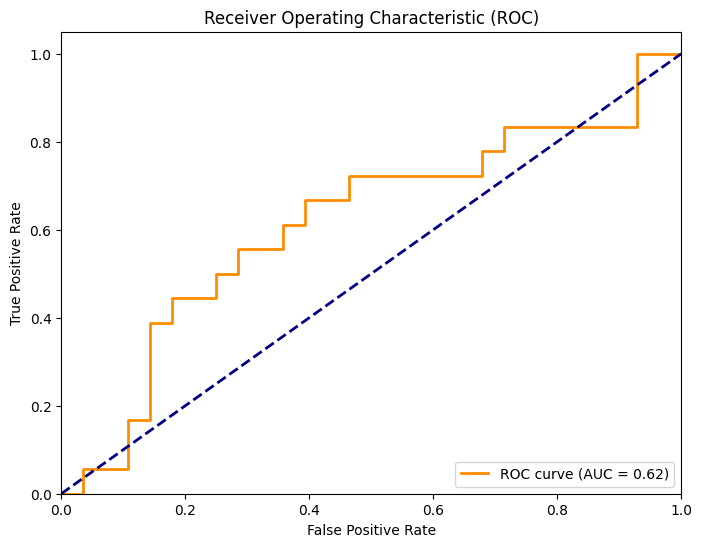

In [220]:

from sklearn.metrics import roc_curve, roc_auc_score

y_prob = model.predict_proba(X_test)[:, 1]

# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Compute the AUC score
roc_auc = roc_auc_score(y_test, y_prob)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

 thresholds

In [221]:
thresholds

array([       inf, 0.9623445 , 0.955615  , 0.9078016 , 0.8841164 ,
       0.88209975, 0.76495296, 0.7185991 , 0.7154066 , 0.6595175 ,
       0.5761024 , 0.5750773 , 0.5620704 , 0.5229844 , 0.51506287,
       0.50764763, 0.4704362 , 0.45773214, 0.45638788, 0.36492112,
       0.2431736 , 0.20383398, 0.18769754, 0.12658533, 0.09223511,
       0.05205392], dtype=float32)

In [222]:
n_thresholds = thresholds[16:20]

In [223]:
n_thresholds =np.linspace(0.9, 0.5, 5)

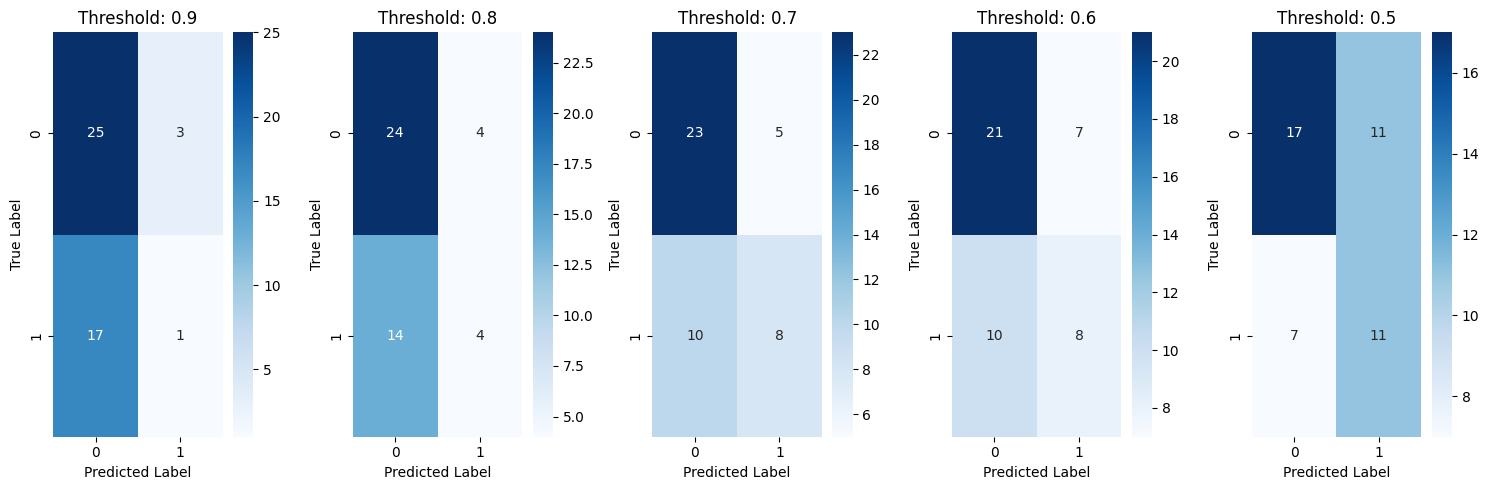

In [224]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, threshold, ax):
    """
    Calculates and plots the confusion matrix for given true and predicted labels at a specified threshold.

    Args:
        y_true (array-like): True labels.
        y_pred (array-like): Predicted probabilities.
        threshold (float): Probability threshold for classification.
        ax (matplotlib.axes._subplots.AxesSubplot): Axis object to plot on.
    """
    y_pred_class = (y_pred > threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred_class)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'Threshold: {threshold}')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')

# Example usage

fig, axes = plt.subplots(1, len(n_thresholds), figsize=(15, 5))

for i, threshold in enumerate(n_thresholds):
    plot_confusion_matrix(y_test, y_prob, threshold, axes[i])

plt.tight_layout()
plt.show()

In [186]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.datasets import make_classification


# Define the XGBoost classifier
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',  # Specify binary classification
    #eval_metric='accuracy',            # Evaluation metric
    #use_label_encoder=False,       # Avoid a warning
    random_state=42
)

# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8]
}

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

# Initialize Grid Search
grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=cv,
    n_jobs=-1, # Use all available cores
    verbose=1
)

# Fit Grid Search to the data
grid_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions on the test set (or the same data for demonstration)
y_prob = best_model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_prob)
print("AUC on the data:", auc_score)

Fitting 2 folds for each of 243 candidates, totalling 486 fits
Best parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.8}
Best score: 0.5714285714285714
AUC on the data: 0.611111111111111


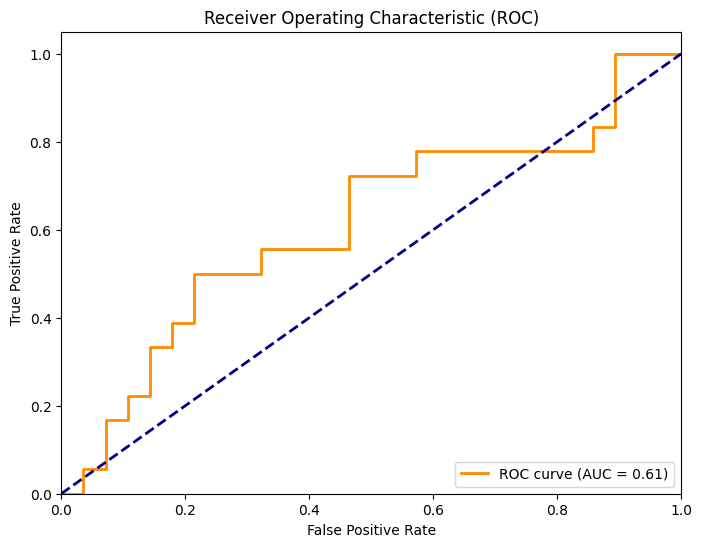

In [187]:
# Compute the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Compute the AUC score
roc_auc = roc_auc_score(y_test, y_prob)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

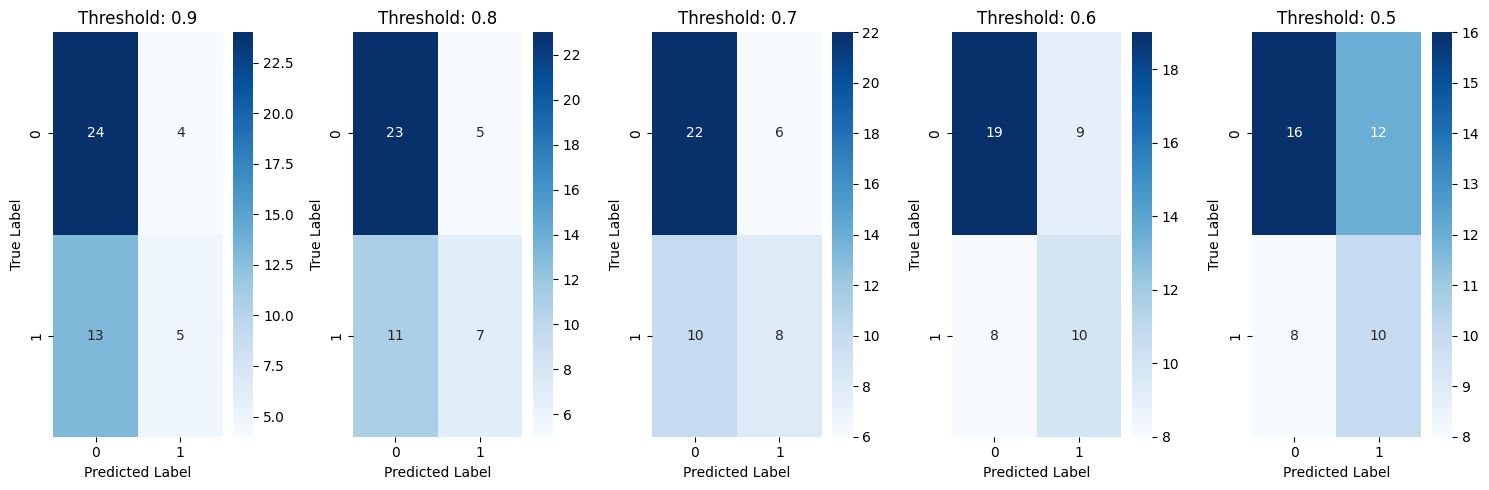

In [189]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

n_thresholds =np.linspace(0.9, 0.5, 5)

fig, axes = plt.subplots(1, len(n_thresholds), figsize=(15, 5))

for i, threshold in enumerate(n_thresholds):
    plot_confusion_matrix(y_test, y_prob, threshold, axes[i])

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
error_rates = []

for n in range(1,96):
    
    model = AdaBoostClassifier(n_estimators=n)
    model.fit(X_train,y_train)
    preds = model.predict(X_test)
    err = 1 - accuracy_score(y_test,preds)
    
    error_rates.append(err)

In [ ]:
plt.plot(range(1,96),error_rates)